In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import scipy
import scipy.signal as sig

In [58]:
# This section will demonstrate the important Features of computing the Fourier Transform of a discrete signal
# Important Take-aways:
# 1.  Leakage Effect 
#     a.  Mitigated by smapling over a longer window
#     b.  Periodicity -> non-periodic signals have additional contributions in DFTF
# 2.  Window choices

In [1]:
def DFTF(sig,Om0,N):
    # Fourier transform of exp signal is integral w.r.t angular freq (Om)
    # Steps for Discrete signal Fourier Transform:
    # ... 1: Truncate signal
    # ... 2: Sampling of DFTF truncated signaled
    dOm   = sig-Om0  # diff of freq
    sineratio = np.sin(N * dOm / 2) / (np.sin(dOm / 2))
    return np.exp(-1j * dOm * (N-1) / 2) * sineratio


def dft_signal_mixture(N, A1, P1, A2, P2,w=1):
    # N: length of signal/DFT
    # A1, P1, A2, P2: amplitude and periodicity of 1st/2nd complex exponential
    
    # generate the signal mixture
    Om0_1 = P1 * (2*np.pi/N)  # frequency of 1st exponential signal
    Om0_2 = P2 * (2*np.pi/N)  # frequency of 2nd exponential signal
    k = np.arange(N)
    x = A1 * np.exp(1j*Om0_1*k) + A2 * np.exp(1j*Om0_2*k)
    x = x * w

    # DFT of the signal mixture
    mu = np.arange(N)
    X = np.fft.fft(x)
    return X,mu

# Helper Function for converting waves to fft power spectrums back and forth
def make_spectrum(datain, ratein):
    n = len(datain)
   # d = 1 ./ ratein  # timestep
    # power spectral density
    hsout = np.fft.rfft(datain)
    # frequency spectrum
    freq = np.fft.rfftfreq(n, d=1./ratein)
    return hsout, freq

def make_spectrogram(wave,ts,seg_length,frate = 10000):
        window = np.hamming(seg_length)
        i, j = 0, seg_length
        step = int(seg_length / 2)
        spec_map = {}
        
        while j < len(wave):
            segment = wave[i:j].copy()
        
            t = (ts[i] + ts[j]) / 2
            spec_map[t],freq = make_spectrum(segment,frate)
            i += step
            j += step
        return spec_map,freq
    
def dft_window_function(w):
    
    N = len(w)
    
    # DFT of window function
    W = np.fft.fft(w, 8192)
    W = np.fft.fftshift(W)
    W = W / np.amax(W) + np.nextafter(0,1)
    mu = np.linspace(-np.pi, np.pi, 8192)

    # plot window function and its spectrum
    plt.rcParams['figure.figsize'] = 10, 5
    plt.stem(w, basefmt=' ')
    plt.xlabel(r'$k$')
    plt.ylabel(r'$w[k]$')
    plt.axis([-1, N+1, -0.1, 1.1])
    plt.grid()

    plt.figure()
    plt.plot(mu, 20*np.log10(np.abs(W)))
    plt.xlabel(r'$\Omega$')
    plt.ylabel(r'$| W(e^{j \Omega}) |$ in dB')
    plt.axis([-np.pi, np.pi, -100, 5])
    plt.grid()

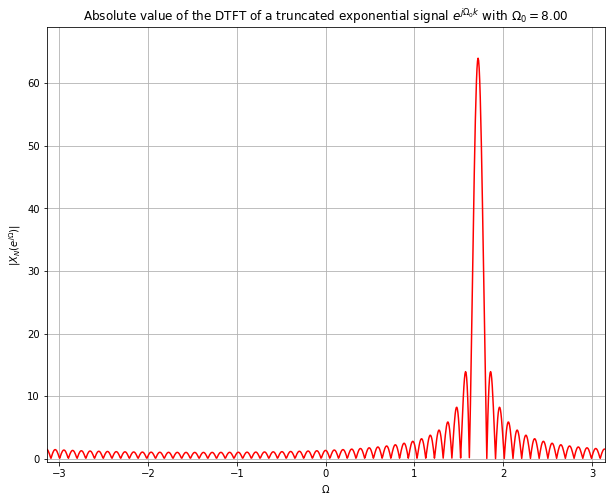

In [60]:
signal = np.linspace(-np.pi, np.pi, num=1024)
freq0  = 8             # Frequency
N      = np.power(2,6) # length of signal
XN     = DFTF(signal,freq0,N)
# plot spectrum
plt.figure(figsize = (10, 8))
plt.plot(signal, abs(XN), 'r')
plt.title(r'Absolute value of the DTFT of a truncated exponential signal $e^{j \Omega_0 k}$ with $\Omega_0=$%2.2f' %freq0)
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$|X_N(e^{j \Omega})|$')
plt.axis([-np.pi, np.pi, -0.5, N+5])
plt.grid()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


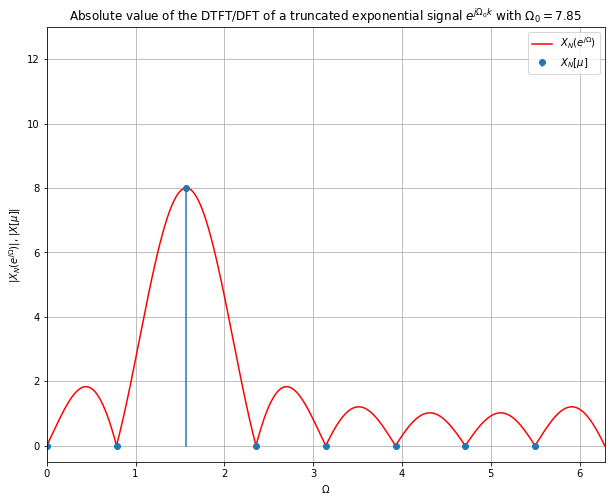

In [61]:
## Comparing DFTF and FFT
N = np.power(2,3)  # length of the signal
P = 10  # periodicity of the exponential signal
Om0 = P * (2*np.pi/N)  # frequency of exponential signal


# truncated exponential signal
x = np.exp(1j*Om0*np.arange(N))

# DTFT of finite length exponential signal (analytic)
signal = np.linspace(0, 2*np.pi, num=1024)
Xw = DFTF(signal,Om0,N)

# DFT of the exponential signal by FFT
X = np.fft.fft(x)
mu = np.arange(N) * 2*np.pi/N

# plot spectra
plt.figure(figsize = (10, 8))
plt.hold(True)

plt.plot(signal, abs(Xw), 'r', label=r'$X_N(e^{j \Omega})$')
plt.stem(mu, abs(X), label=r'$X_N[\mu]$', basefmt=' ')
plt.title(r'Absolute value of the DTFT/DFT of a truncated exponential signal $e^{j \Omega_0 k}$ with $\Omega_0=$%2.2f' %Om0)

plt.xlabel(r'$\Omega$')
plt.ylabel(r'$|X_N(e^{j \Omega})|$, $|X[\mu]|$')
plt.axis([0, 2*np.pi, -0.5, N+5]);
plt.legend()
plt.grid()

plt.show()

* Noticed how the frequency magnitude is not clearly captured for both signals
Leakage Effect:
	It limits the achievable frequency resolution of the DFT when analyzing signal mixtures 
consisting of more than one exponential signal.


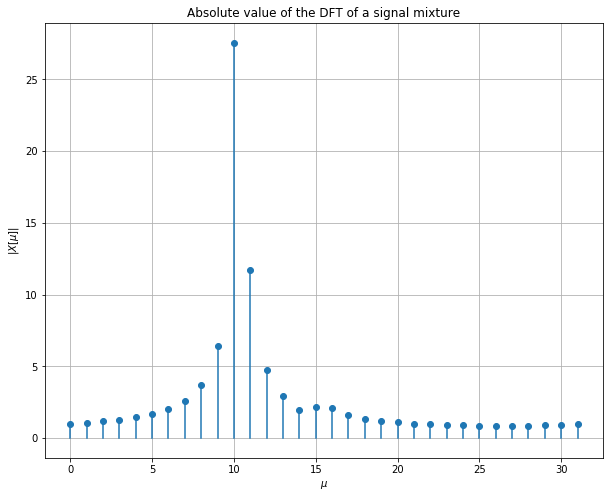

In [50]:
N = np.power(2,5)
# Parameters                  signal 1 & signal 2
X2,mu2 = dft_signal_mixture(N, 1, 10.3, 0.1, 15.2)

# plot spectrum
plt.figure(figsize = (10, 8))
plt.stem(mu2, abs(X2), basefmt=' ')
plt.title(r'Absolute value of the DFT of a signal mixture')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$|X[\mu]|$')
plt.grid()
print('* Noticed how the frequency magnitude is not clearly captured for both signals')
print('Leakage Effect:\n\tIt limits the achievable frequency resolution of the DFT when analyzing signal mixtures \nconsisting of more than one exponential signal.')


Notice how the DFTF Frequency Transform become more clear when using a pre-designed window 


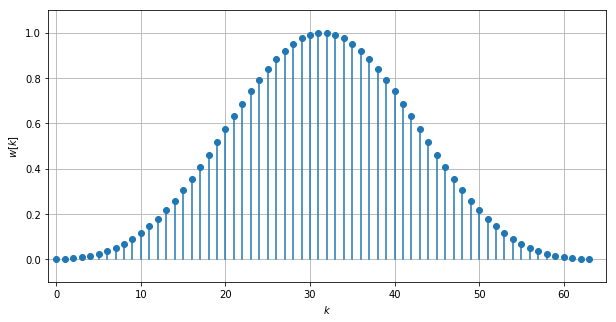

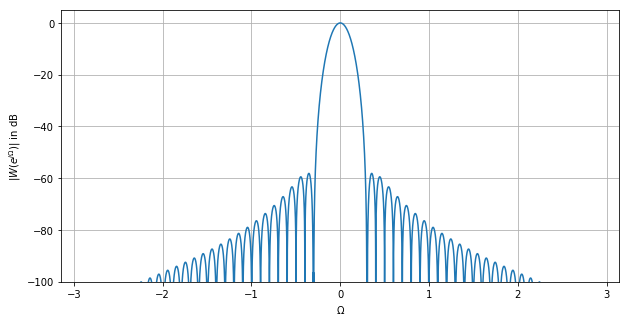

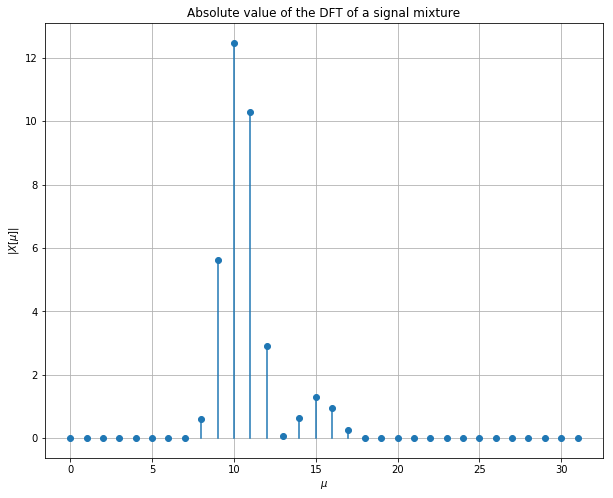

In [62]:
## Effects of designing truncation windows
#dft_window_function(np.ones(64))
#dft_window_function(sig.triang(63))
#dft_window_function(np.hanning(64))
dft_window_function(np.blackman(64))

# Look how the signal clarity increases by changing the window
N = np.power(2,5)
# Parameters                  signal 1 & signal 2
X2,mu2 = dft_signal_mixture(32, 1, 10.3, 0.1, 15.2, np.blackman(32))

# plot spectrum
plt.figure(figsize = (10, 8))
plt.stem(mu2, abs(X2), basefmt=' ')
plt.title(r'Absolute value of the DFT of a signal mixture')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$|X[\mu]|$')
plt.grid()
print("Notice how the DFTF Frequency Transform become more clear when using a pre-designed window ")

The additional coefficients are related by bandlimited interpolation to the original ones.
- In general, zero-padding does not bring a benefit in spectral analysis. 
- It may bring a benefit in special applications,
	for instance when estimating the frequency of an isolated harmonic signal from its spectrum which is illustrated in the following example.


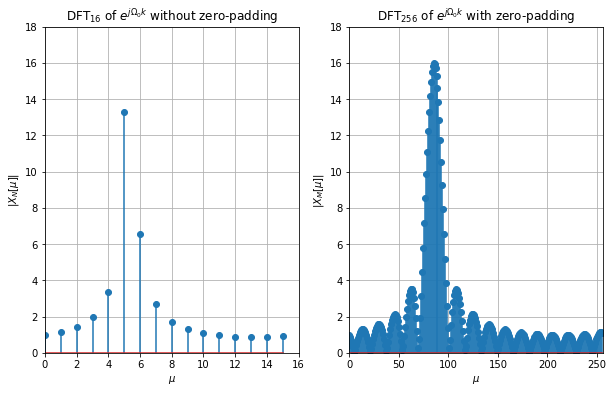

In [100]:
N = 16  # length of the signal
M = 256  # length of zero-padded signal
Om0 = 5.33*(2*np.pi/N)  # frequency of exponential signal


# DFT of the exponential signal
xN = np.exp(1j*Om0*np.arange(N))
XN = np.fft.fft(xN)
# DFT of the zero-padded exponential signal
xM = np.concatenate((xN, np.zeros(M-N)))
XM = np.fft.fft(xM)

# plot spectra
plt.figure(figsize = (10, 6))

plt.subplot(121)
plt.stem(np.arange(N),np.abs(XN))
plt.title(r'DFT$_{%d}$ of $e^{j \Omega_0 k}$ without zero-padding' %N)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$|X_N[\mu]|$')
plt.axis([0, N, 0, 18])
plt.grid()

plt.subplot(122)
plt.stem(np.arange(M),np.abs(XM))
plt.title(r'DFT$_{%d}$ of $e^{j \Omega_0 k}$ with zero-padding' %M)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$|X_M[\mu]|$')
plt.axis([0, M, 0, 18])
plt.grid()
print("The additional coefficients are related by bandlimited interpolation to the original ones.")
print("- In general, zero-padding does not bring a benefit in spectral analysis. ")
print("- It may bring a benefit in special applications,")
print("\tfor instance when estimating the frequency of an isolated harmonic signal from its spectrum which is illustrated in the following example.")


In [108]:
muM = np.argmax(np.abs(XM))
muN = np.argmax(np.abs(XN))
print("The estimated frequency from the original signal is \n- Ω= μN ~ ",muN)
print("The estimated frequency from the zero padded signal is \n- Ω= μM/(M/N) ~ ",muM/(M/N))

print("\nWARNING:  BE CAREFUL IN YOUR INTERPRETATION")
print("\tAll spectral information of a signal of finite length N is already contained in its spectrum derived from a DFT of length N. By applying zero-padding and a longer DFT, the frequency resolution is only virtually increased. The additional coefficients are related by bandlimited interpolation to the original ones. ")

The estimated frequency from the original signal is 
- Ω= μN ~  5
The estimated frequency from the zero padded signal is 
- Ω= μM/(M/N) ~  5.3125

	All spectral information of a signal of finite length N is already contained in its spectrum derived from a DFT of length N. By applying zero-padding and a longer DFT, the frequency resolution is only virtually increased. The additional coefficients are related by bandlimited interpolation to the original ones. 


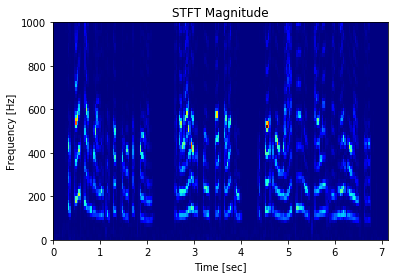

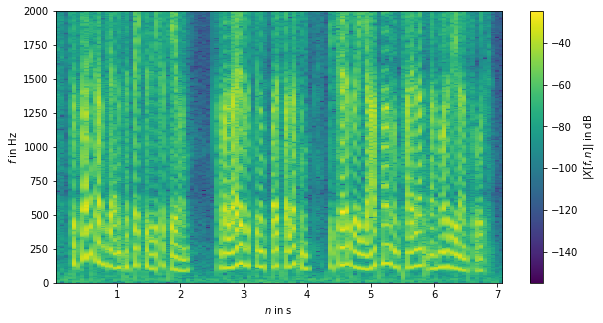

In [24]:
import scipy.io.wavfile
datafolder = '/Users/maxmaguire/Desktop/PostGradWork/DataFolder/SampleAudioFiles/'
fname = datafolder + '/speech_8k.wav'
rate, data = scipy.io.wavfile.read(fname)
sd.play(data[:],rate)

f, t, Zxx = sig.stft(data, rate, nperseg=seg_length)
plt.pcolormesh(t, f, np.abs(Zxx),cmap='jet')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([0,1000])
plt.show()


L = 1024  # length of one segment
overlap = 512  # overlap between segments
x = data[:]/np.max(np.abs(data[:]))

# compute and plot spectrogram
plt.figure(figsize = (10, 5))
plt.specgram(x, NFFT=L, Fs=rate, noverlap=overlap, sides='onesided')
plt.xlabel(r'$n$ in s')
plt.ylabel(r'$f$ in Hz')
cb = plt.colorbar()
cb.set_label(r'$|X[f,n]|$ in dB')
plt.autoscale(tight=True)
plt.ylim([0, 2000]);